In [1]:
import sys
sys.path.append("../scripts")

In [42]:
## General
import pandas as pd
import numpy as np

## Data cleaning/setup
from clean_data import load_and_clean_data
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

## Evaluation metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

## Other
pd.set_option('display.max_rows', 400)

## Functions

In [3]:
def upsample(X, y):
    idx_class_1 = np.where(y == 1)[0]
    class_1 = X.iloc[idx_class_1]
    n_resample = len(X) - len(idx_class_1)
    X_upsampled = resample(class_1, n_samples = n_resample, random_state = 42)
    y_upsampled = y.loc[X_upsampled.index]
    X_up = pd.concat([X_upsampled, X.iloc[np.where(y == 0)[0]]])
    y_up = pd.concat([y_upsampled, y.iloc[np.where(y == 0)[0]]])
    
    return X_up, y_up

In [4]:
def run_model(X_train, y_train, X_val, y_val, model = DecisionTreeClassifier()):
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    
    return model, y_pred, roc_auc, fpr, tpr

## Data

#### Pull and split data

In [5]:
X_train, X_test, y_train, y_test = load_and_clean_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state = 42)

C:\Users\prest\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (10,17,19,23,25,27,28,29,30,32,33,36,37,38,39,40,41,42,43,50,51,83,86,89,92,94,95,97,100,103,106,110,113,116,121,124,127,130,133,136,188,190,201,212,231,232,242,244,247,249,256,262,267,273,279,280,281,282,283,284,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,305,318,320,333,334) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\prest\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\prest\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying

#### Feature selection

In [6]:
selected_features = pd.read_csv('feature_selection_final_columns.csv', names=["feats"], skiprows=1)

In [7]:
selected_features = selected_features.feats.values

X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_test = X_test[selected_features]

#### Upsampling

In [8]:
X_train_up, y_train_up = upsample(X_train, y_train)

## Hyperparameters

#### Logistic Regression

In [12]:
## Defaults
lr_params = {'penalty':'l2', 'C':1.0, 'max_iter':100, 'solver':'liblinear'}

In [13]:
## Tuned
lr_params = {'penalty':'l1', 'C':1, 'max_iter':300, 'solver':'liblinear'}

#### Decision Tree

In [14]:
## Defaults
dt_params = {'max_depth':None, 'min_samples_split':2, 'min_samples_leaf':1}

In [15]:
## Tuned
dt_params = {'max_depth':10, 'min_samples_split':1000, 'min_samples_leaf':100}

#### Random Forest

In [16]:
## Defaults
rf_params = {'max_depth':None, 'min_samples_split':2, 'min_samples_leaf':1}

In [17]:
## Tuned
rf_params = {'max_depth':50, 'min_samples_split':2, 'min_samples_leaf':10, 'n_estimators':200}

#### XGBoost

In [18]:
## Default
xgb_params = {'max_depth': 6, 'eta': 0.3, 'eval_metric':'auc'}

In [19]:
## Tuned
xgb_params = {'max_depth': 6, 'eta': 0.1, 'eval_metric':'auc'}

#### Full parameter dictionary

In [20]:
param_dict = {'lr':lr_params, 'dt':dt_params, 'rf':rf_params, 'xgb':xgb_params}

In [21]:
param_dict

{'lr': {'penalty': 'l1', 'C': 1, 'max_iter': 300, 'solver': 'liblinear'},
 'dt': {'max_depth': 10, 'min_samples_split': 1000, 'min_samples_leaf': 100},
 'rf': {'max_depth': 50,
  'min_samples_split': 2,
  'min_samples_leaf': 10,
  'n_estimators': 200},
 'xgb': {'max_depth': 6, 'eta': 0.1, 'eval_metric': 'auc'}}

## Modelling

In [22]:
results = {}

#### Logistic Regression

In [20]:
lr = LogisticRegression(**param_dict['lr'])
lr_mod, lr_pred, lr_auc, lr_fpr, lr_tpr = run_model(X_train_up, y_train_up, X_val, y_val, model=lr)
results["Logistic Regression"] = {'pred':lr_pred, 'fpr':lr_fpr, 'tpr':lr_tpr, 'auc':lr_auc}

C:\Users\prest\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [21]:
lr_auc

0.7522088874012882

#### Decision Tree

In [22]:
dt = DecisionTreeClassifier(**param_dict['dt'])
dt_mod, dt_pred, dt_auc, dt_fpr, dt_tpr = run_model(X_train, y_train, X_val, y_val, model=dt)
results["Decision Tree"] = {'pred':dt_pred, 'fpr':dt_fpr, 'tpr':dt_tpr, 'auc':dt_auc}

In [23]:
dt_auc

0.7585016500760663

#### Random Forest

In [24]:
rf = RandomForestClassifier(**param_dict['rf'])
rf_mod, rf_pred, rf_auc, rf_fpr, rf_tpr = run_model(X_train, y_train, X_val, y_val, model=rf)
results["Random Forest"] = {'pred':rf_pred, 'fpr':rf_fpr, 'tpr':rf_tpr, 'auc':rf_auc}

In [25]:
rf_auc

0.7715711586710071

#### XGBoost

In [23]:
bst = xgb.XGBClassifier(**param_dict['xgb'])
bst_mod, bst_pred, bst_auc, bst_fpr, bst_tpr = run_model(X_train, y_train, X_val, y_val, model=bst)
results["XGBoost"] = {'pred':bst_pred, 'fpr':bst_fpr, 'tpr':bst_tpr, 'auc':bst_auc}

C:\Users\prest\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [24]:
bst_auc

0.7797098025014082

## Plotting

In [28]:
for r in results:
    print(r)

Logistic Regression
Decision Tree
Random Forest
XGBoost


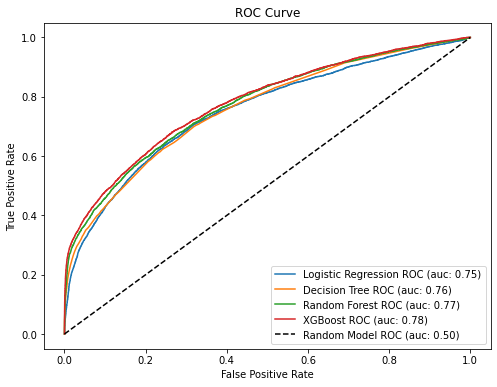

In [29]:
plt.figure(figsize = (8,6))
for mod in results:
    plt.plot(results[mod]['fpr'], results[mod]['tpr'], label='%s ROC (auc: %.2f)' %(mod, results[mod]['auc']))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label = 'Random Model ROC (auc: 0.50)')
plt.legend(loc = 'lower right')
plt.savefig('../plots/roc_curve.pdf')

In [30]:
## Precision-recall curves

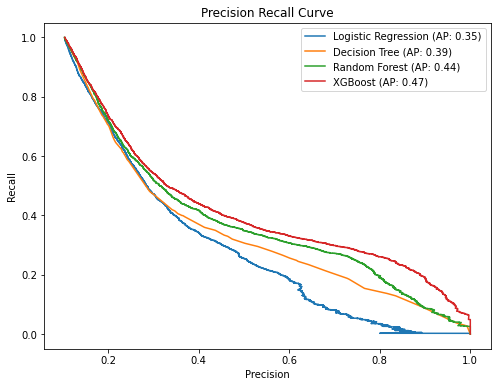

In [31]:
plt.figure(figsize = (8,6))
for mod in results:
    prec, rec, thresh = precision_recall_curve(y_val, results[mod]['pred'])
    ap = average_precision_score(y_val, results[mod]['pred'])
    plt.plot(prec, rec, label='%s (AP: %.2f)' %(mod, ap))
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision Recall Curve')
plt.legend(loc = 'upper right')
plt.savefig('../plots/prec_rec.pdf')

In [32]:
## Individual precision, recall, sensitivity, specificity

In [33]:
## Precision

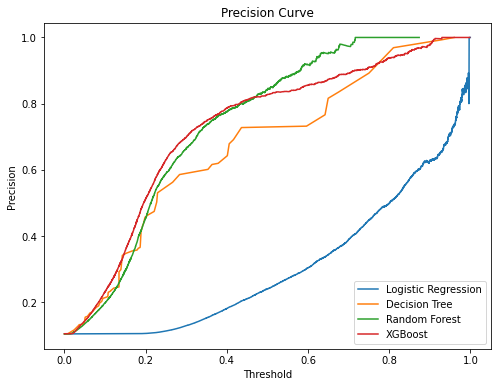

In [34]:
plt.figure(figsize = (8,6))
for mod in results:
    prec, rec, thresh = precision_recall_curve(y_val, results[mod]['pred'])
    plt.plot(np.append(0, thresh), prec, label='%s' %mod)
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    plt.title('Precision Curve')
plt.legend(loc = 'lower right')
plt.savefig('../plots/prec_curve.pdf')

In [35]:
## Recall

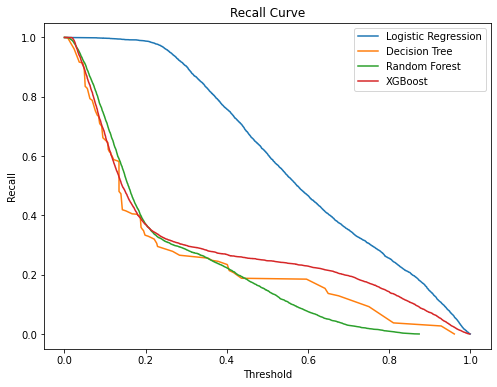

In [36]:
plt.figure(figsize = (8,6))
for mod in results:
    prec, rec, thresh = precision_recall_curve(y_val, results[mod]['pred'])
    plt.plot(np.append(0, thresh), rec, label='%s' %mod)
    plt.xlabel('Threshold')
    plt.ylabel('Recall')
    plt.title('Recall Curve')
plt.legend(loc = 'upper right')
plt.savefig('../plots/rec_curve.pdf')

In [37]:
## Specificity

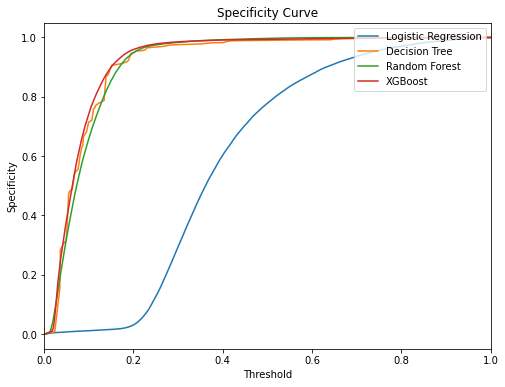

In [38]:
plt.figure(figsize = (8,6))
for mod in results:
    fpr, tpr, thresh = roc_curve(y_val, results[mod]['pred'])
    plt.plot(thresh, 1 - fpr, label='%s' %mod)
    plt.xlim(0, 1)
    plt.xlabel('Threshold')
    plt.ylabel('Specificity')
    plt.title('Specificity Curve')
plt.legend(loc = 'upper right')
plt.savefig('../plots/spec_curve.pdf')

In [39]:
## Sensitivity

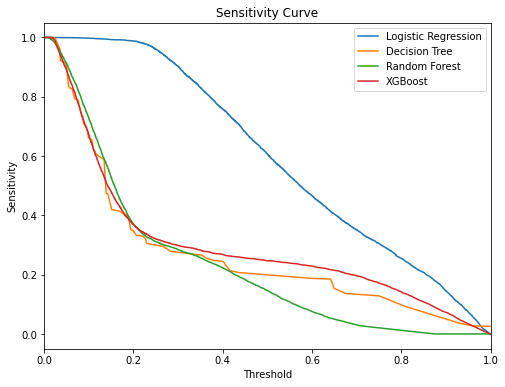

In [40]:
plt.figure(figsize = (8,6))
for mod in results:
    fpr, tpr, thresh = roc_curve(y_val, results[mod]['pred'])
    plt.plot(thresh, tpr, label='%s' %mod)
    plt.xlim(0, 1)
    plt.xlabel('Threshold')
    plt.ylabel('Sensitivity')
    plt.title('Sensitivity Curve')
plt.legend(loc = 'upper right')
plt.savefig('../plots/sens_curve.pdf')

In [41]:
## F-scores

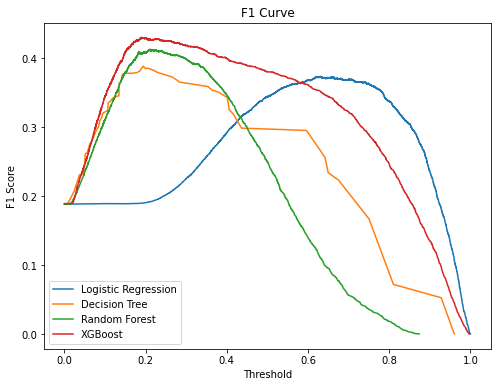

In [42]:
plt.figure(figsize = (8,6))
for mod in results:
    prec, rec, thresh = precision_recall_curve(y_val, results[mod]['pred'])
    f1 = 2 * (prec * rec) / (prec + rec)
    plt.plot(np.append(0, thresh), f1, label='%s' %mod)
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Curve')
plt.legend(loc = 'lower left')
plt.savefig('../plots/f1_curve.pdf')

In [43]:
## Waterfall plots

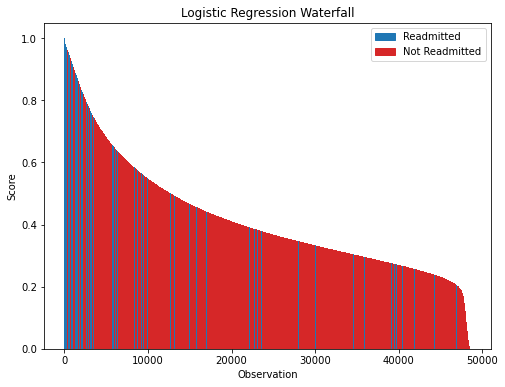

In [44]:
x = np.arange(len(lr_pred))

sort_idx = np.argsort(-lr_pred)
y = lr_pred[sort_idx]

y_col = y_val.iloc[sort_idx]
y_col = np.where(y_col==1, 'C0', 'C3')

plt.figure(figsize = (8,6))
plt.bar(x, y, color = y_col, width=1.0)

plt.title('Logistic Regression Waterfall')
plt.xlabel('Observation')
plt.ylabel('Score')

leg_text = [mpatches.Patch(color='C0', label='Readmitted'),
    mpatches.Patch(color='C3', label='Not Readmitted')]
plt.legend(handles=leg_text, loc='upper right')
plt.savefig('../plots/lr_waterfall.pdf')

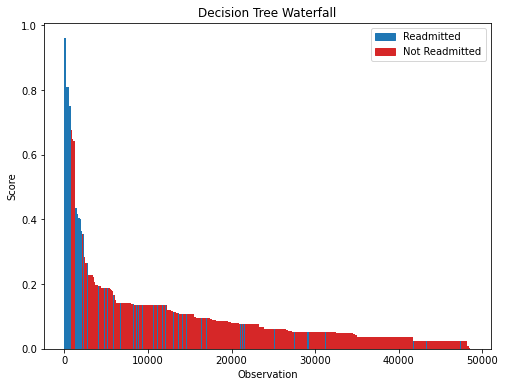

In [45]:
x = np.arange(len(dt_pred))

sort_idx = np.argsort(-dt_pred)
y = dt_pred[sort_idx]

y_col = y_val.iloc[sort_idx]
y_col = np.where(y_col==1, 'C0', 'C3')

plt.figure(figsize = (8,6))
plt.bar(x, y, color = y_col, width=1.0)

plt.title('Decision Tree Waterfall')
plt.xlabel('Observation')
plt.ylabel('Score')

leg_text = [mpatches.Patch(color='C0', label='Readmitted'),
    mpatches.Patch(color='C3', label='Not Readmitted')]
plt.legend(handles=leg_text, loc='upper right')
plt.savefig('../plots/dt_waterfall.pdf')

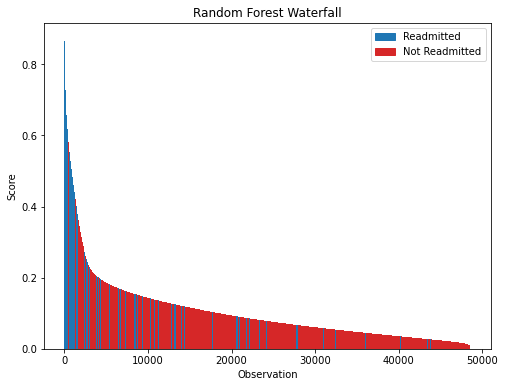

In [46]:
x = np.arange(len(rf_pred))

sort_idx = np.argsort(-rf_pred)
y = rf_pred[sort_idx]

y_col = y_val.iloc[sort_idx]
y_col = np.where(y_col==1, 'C0', 'C3')

plt.figure(figsize = (8,6))
plt.bar(x, y, color = y_col, width=1.0)

plt.title('Random Forest Waterfall')
plt.xlabel('Observation')
plt.ylabel('Score')

leg_text = [mpatches.Patch(color='C0', label='Readmitted'),
    mpatches.Patch(color='C3', label='Not Readmitted')]
plt.legend(handles=leg_text, loc='upper right')
plt.savefig('../plots/rf_waterfall.pdf')

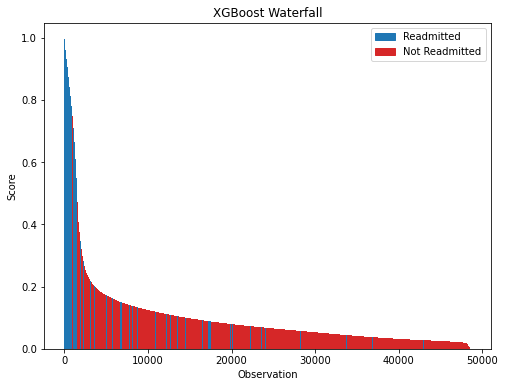

In [47]:
x = np.arange(len(bst_pred))

sort_idx = np.argsort(-bst_pred)
y = bst_pred[sort_idx]

y_col = y_val.iloc[sort_idx]
y_col = np.where(y_col==1, 'C0', 'C3')

plt.figure(figsize = (8,6))
plt.bar(x, y, color = y_col, width=1.0)

plt.title('XGBoost Waterfall')
plt.xlabel('Observation')
plt.ylabel('Score')

leg_text = [mpatches.Patch(color='C0', label='Readmitted'),
    mpatches.Patch(color='C3', label='Not Readmitted')]
plt.legend(handles=leg_text, loc='upper right')
plt.savefig('../plots/xg_waterfall.pdf')

---

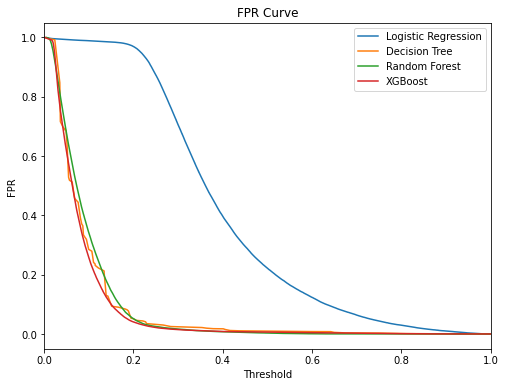

In [48]:
plt.figure(figsize = (8,6))
for mod in results:
    fpr, tpr, thresh = roc_curve(y_val, results[mod]['pred'])
    plt.plot(thresh, fpr, label='%s' %mod)
    plt.xlim(0, 1)
    plt.xlabel('Threshold')
    plt.ylabel('FPR')
    plt.title('FPR Curve')
plt.legend(loc = 'upper right')
plt.savefig('../plots/fpr_curve.pdf')

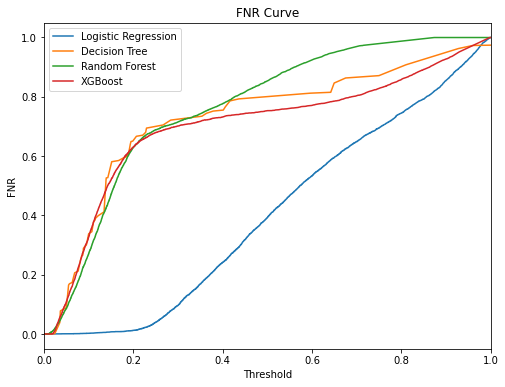

In [49]:
plt.figure(figsize = (8,6))
for mod in results:
    fpr, tpr, thresh = roc_curve(y_val, results[mod]['pred'])
    plt.plot(thresh, 1 - tpr, label='%s' %mod)
    plt.xlim(0, 1)
    plt.xlabel('Threshold')
    plt.ylabel('FNR')
    plt.title('FNR Curve')
plt.legend(loc = 'upper left')
plt.savefig('../plots/fnr_curve.pdf')

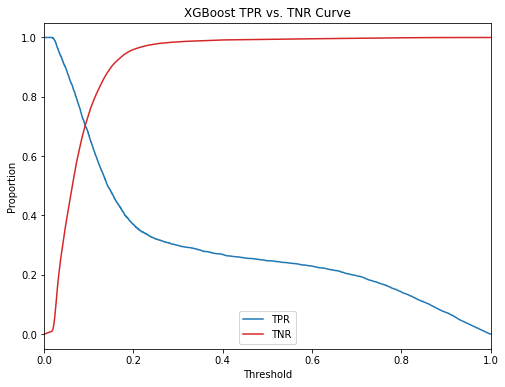

In [50]:
plt.figure(figsize = (8,6))
fpr, tpr, thresh = roc_curve(y_val, results['XGBoost']['pred'])
plt.plot(thresh, tpr, label='TPR', color='C0')
plt.plot(thresh, 1 - fpr, label='TNR', color='C3')
plt.xlim(0, 1)
plt.xlabel('Threshold')
plt.ylabel('Proportion')
plt.title('XGBoost TPR vs. TNR Curve')
plt.legend(loc = 'lower center')
plt.savefig('../plots/tpr_tnr.pdf')

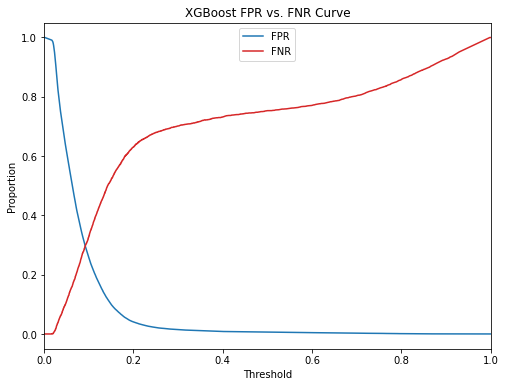

In [51]:
plt.figure(figsize = (8,6))
fpr, tpr, thresh = roc_curve(y_val, results['XGBoost']['pred'])
plt.plot(thresh, fpr, label='FPR', color='C0')
plt.plot(thresh, 1 - tpr, label='FNR', color='C3')
plt.xlim(0, 1)
plt.xlabel('Threshold')
plt.ylabel('Proportion')
plt.title('XGBoost FPR vs. FNR Curve')
plt.legend(loc = 'upper center')
plt.savefig('../plots/fpr_fnr.pdf')

In [27]:
## Confusion matrix (XGBoost)

In [34]:
decision_threshold = 0.5
y_pred = np.where(bst_pred >= decision_threshold, 1, 0)

cm = confusion_matrix(y_val, y_pred)
cm_norm = confusion_matrix(y_val, y_pred, normalize='true')

disp = ConfusionMatrixDisplay(cm)
disp_norm = ConfusionMatrixDisplay(cm_norm)

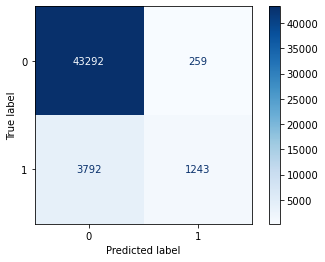

In [61]:
disp.plot(cmap=plt.cm.Blues)
plt.savefig('../plots/conf_mat.pdf')

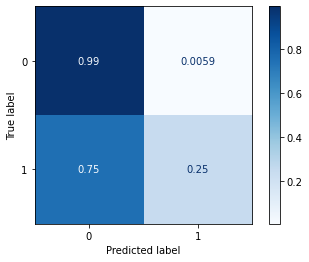

In [62]:
disp_norm.plot(cmap=plt.cm.Blues)
plt.savefig('../plots/conf_mat_norm.pdf')

---

## Clinical Intuition

### Validation Set

In [52]:
## How much improvement in admission predictions is there relative to the original data?

In [53]:
## "Doctor model" correctness
1 - y_val.sum()/len(y_val)

0.8963693244967686

In [54]:
## Best (XGBoost) model correctness

In [55]:
bst_pred01 = bst_mod.predict(X_val)

In [56]:
(bst_pred01 == y_val).sum()/len(y_val)

0.9166220722018689

In [57]:
## Proportion of patients retained who didn't need it (XGBoost)

In [58]:
((bst_pred01==1) & (y_val==0)).sum()/len(y_val)

0.005330753715061952

In [59]:
## Proportion of patients sent home who needed to be readmitted (XGBoost)

In [60]:
((bst_pred01==0) & (y_val==1)).sum()/len(y_val)

0.0780471740830692

In [61]:
## Proprotion of patients correctly retained by "Best" model relative to "Doctor model"

In [62]:
y_val.sum()/len(y_val) - ((bst_pred01==0) & (y_val==1)).sum()/len(y_val)

0.025583501420162177

### Test Set

In [63]:
## How much improvement in admission predictions is there relative to the original data?

In [64]:
## "Doctor model" correctness
doc_prop = y_test.sum()/len(y_test)
doc_prop

0.102065388533852

In [65]:
y_test.sum()

2204.0

In [66]:
## Best (XGBoost) model correctness

In [67]:
bst_pred01 = bst_mod.predict(X_test)

In [68]:
(bst_pred01 == y_test).sum()/len(y_test)

0.9162267296471241

In [69]:
## Proportion of patients retained who didn't need it (XGBoost)

In [70]:
((bst_pred01==1) & (y_test==0)).sum()/len(y_test)

0.005603408354172455

In [71]:
((bst_pred01==1) & (y_test==0)).sum()

121

In [72]:
## Proportion of patients sent home who needed to be readmitted (XGBoost)

In [73]:
mod_prop = ((bst_pred01==0) & (y_test==1)).sum()/len(y_test)
mod_prop

0.07816986199870335

In [74]:
((bst_pred01==0) & (y_test==1)).sum()

1688

In [75]:
## Proprotion of patients correctly retained by "Best" model relative to "Doctor model"

In [76]:
y_test.sum()/len(y_test) - ((bst_pred01==0) & (y_test==1)).sum()/len(y_test)

0.023895526535148648

In [77]:
mod_prop/doc_prop

0.7658802177858439

In [79]:
## Final auc
bst_mod, bst_pred, bst_auc, bst_fpr, bst_tpr = run_model(X_train, y_train, X_test, y_test, model=bst)

C:\Users\prest\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [80]:
bst_auc

0.7754889955811974